<h1>Time Series Profiling</h1>

<h2 align="center">Data Distribution</h2>

In [1]:
from numpy import sum
from pandas import DataFrame, Series, read_csv
from matplotlib.pyplot import figure, show
from dslabs_functions import HEIGHT, plot_line_chart, ts_aggregation_by

file_tag = "timeseries_traffic"
target = "Total"
filepath = "../../../data/forecast_traffic_single.csv"
data: DataFrame = read_csv(
    filepath,
    index_col="Timestamp",
    sep=",",
    decimal=".",
    parse_dates=True,
    infer_datetime_format=True,
)
data = data.sort_values(['Timestamp'], ascending=True)
series: Series = data[target]
ss_hourly = ts_aggregation_by(series, gran_level="H", agg_func=sum)
ss_daily: Series = ts_aggregation_by(series, gran_level="D", agg_func=sum)

<h3>5-Number Summary</h3>

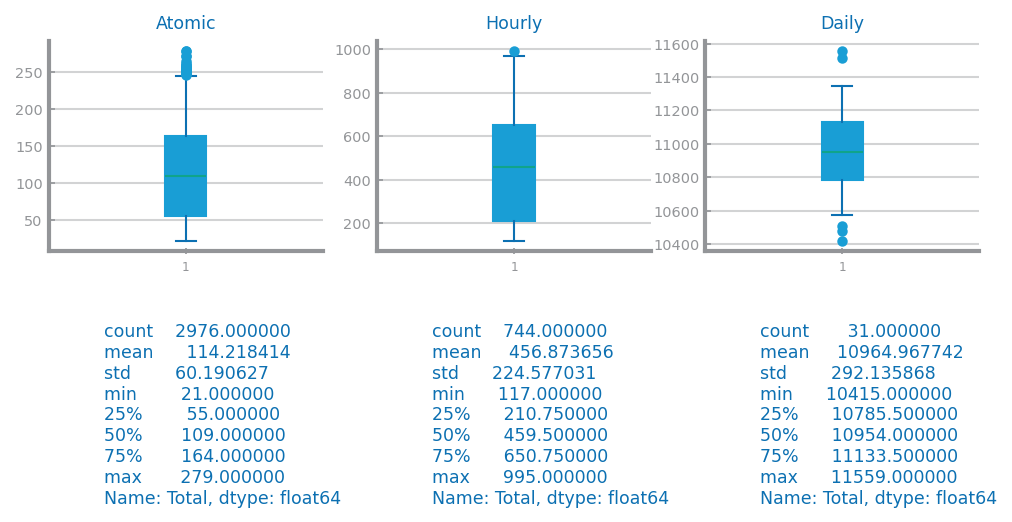

In [5]:
from numpy import array
from matplotlib.pyplot import show, subplots
from matplotlib.figure import Figure
from dslabs_functions import set_chart_labels

fig, axs = subplots(2, 3, figsize=(2 * HEIGHT, HEIGHT))

set_chart_labels(axs[0, 0], title="Atomic")
axs[0, 0].boxplot(series)

set_chart_labels(axs[0, 1], title="Hourly")
axs[0, 1].boxplot(ss_hourly)

set_chart_labels(axs[0, 2], title="Daily")
axs[0, 2].boxplot(ss_daily)


axs[1, 0].grid(False)
axs[1, 0].set_axis_off()
axs[1, 0].text(0.2, 0, str(series.describe()), fontsize="small")

axs[1, 1].grid(False)
axs[1, 1].set_axis_off()
axs[1, 1].text(0.2, 0, str(ss_hourly.describe()), fontsize="small")

axs[1, 2].grid(False)
axs[1, 2].set_axis_off()
axs[1, 2].text(0.2, 0, str(ss_daily.describe()), fontsize="small")

fig.savefig(fname=f"./images/{file_tag}_boxplots.png", bbox_inches="tight")
show()

<h3>Variables Distribution</h3>

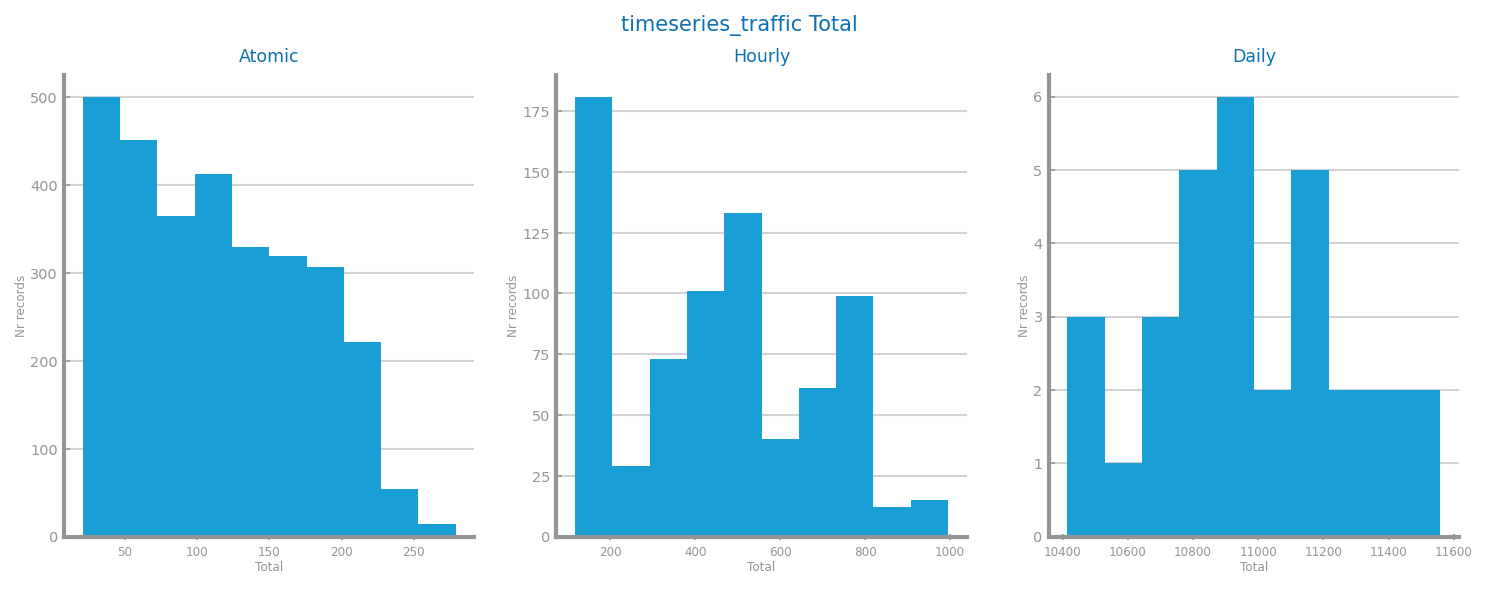

In [7]:
grans: list[Series] = [series, ss_hourly, ss_daily]
gran_names: list[str] = ["Atomic", "Hourly", "Daily"]
fig: Figure
axs: array
fig, axs = subplots(1, len(grans), figsize=(len(grans) * HEIGHT, HEIGHT))
fig.suptitle(f"{file_tag} {target}")

for i in range(len(grans)):
    set_chart_labels(axs[i], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[i].hist(grans[i].values)
fig.savefig(fname=f"./images/{file_tag}_histograms.png", bbox_inches="tight")
show()

<h3>Autocorrelation</h3>

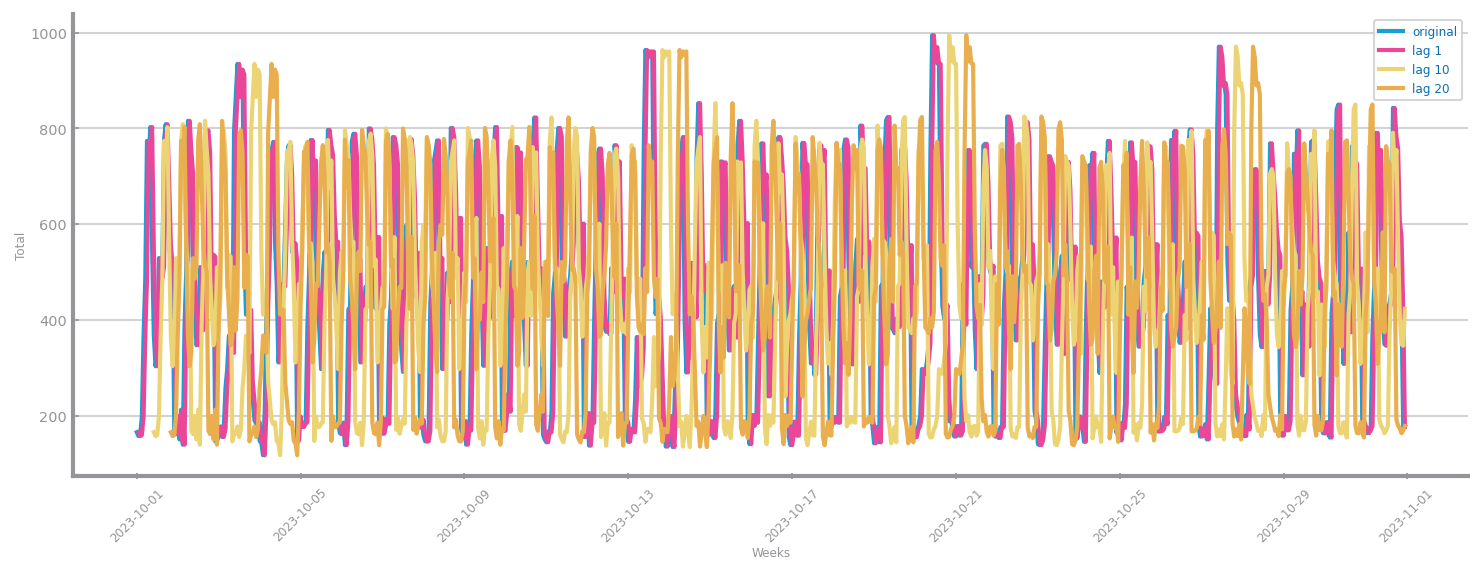

In [8]:
from dslabs_functions import plot_multiline_chart


def get_lagged_series(series: Series, max_lag: int, delta: int = 1):
    lagged_series: dict = {"original": series, "lag 1": series.shift(1)}
    for i in range(delta, max_lag + 1, delta):
        lagged_series[f"lag {i}"] = series.shift(i)
    return lagged_series


fig = figure(figsize=(3 * HEIGHT, HEIGHT))
lags = get_lagged_series(ss_hourly, 20, 10)
plot_multiline_chart(ss_hourly.index.to_list(), lags, xlabel="Weeks", ylabel=target)
fig.savefig(f"./images/{file_tag}_autocorrelation.png", bbox_inches='tight')

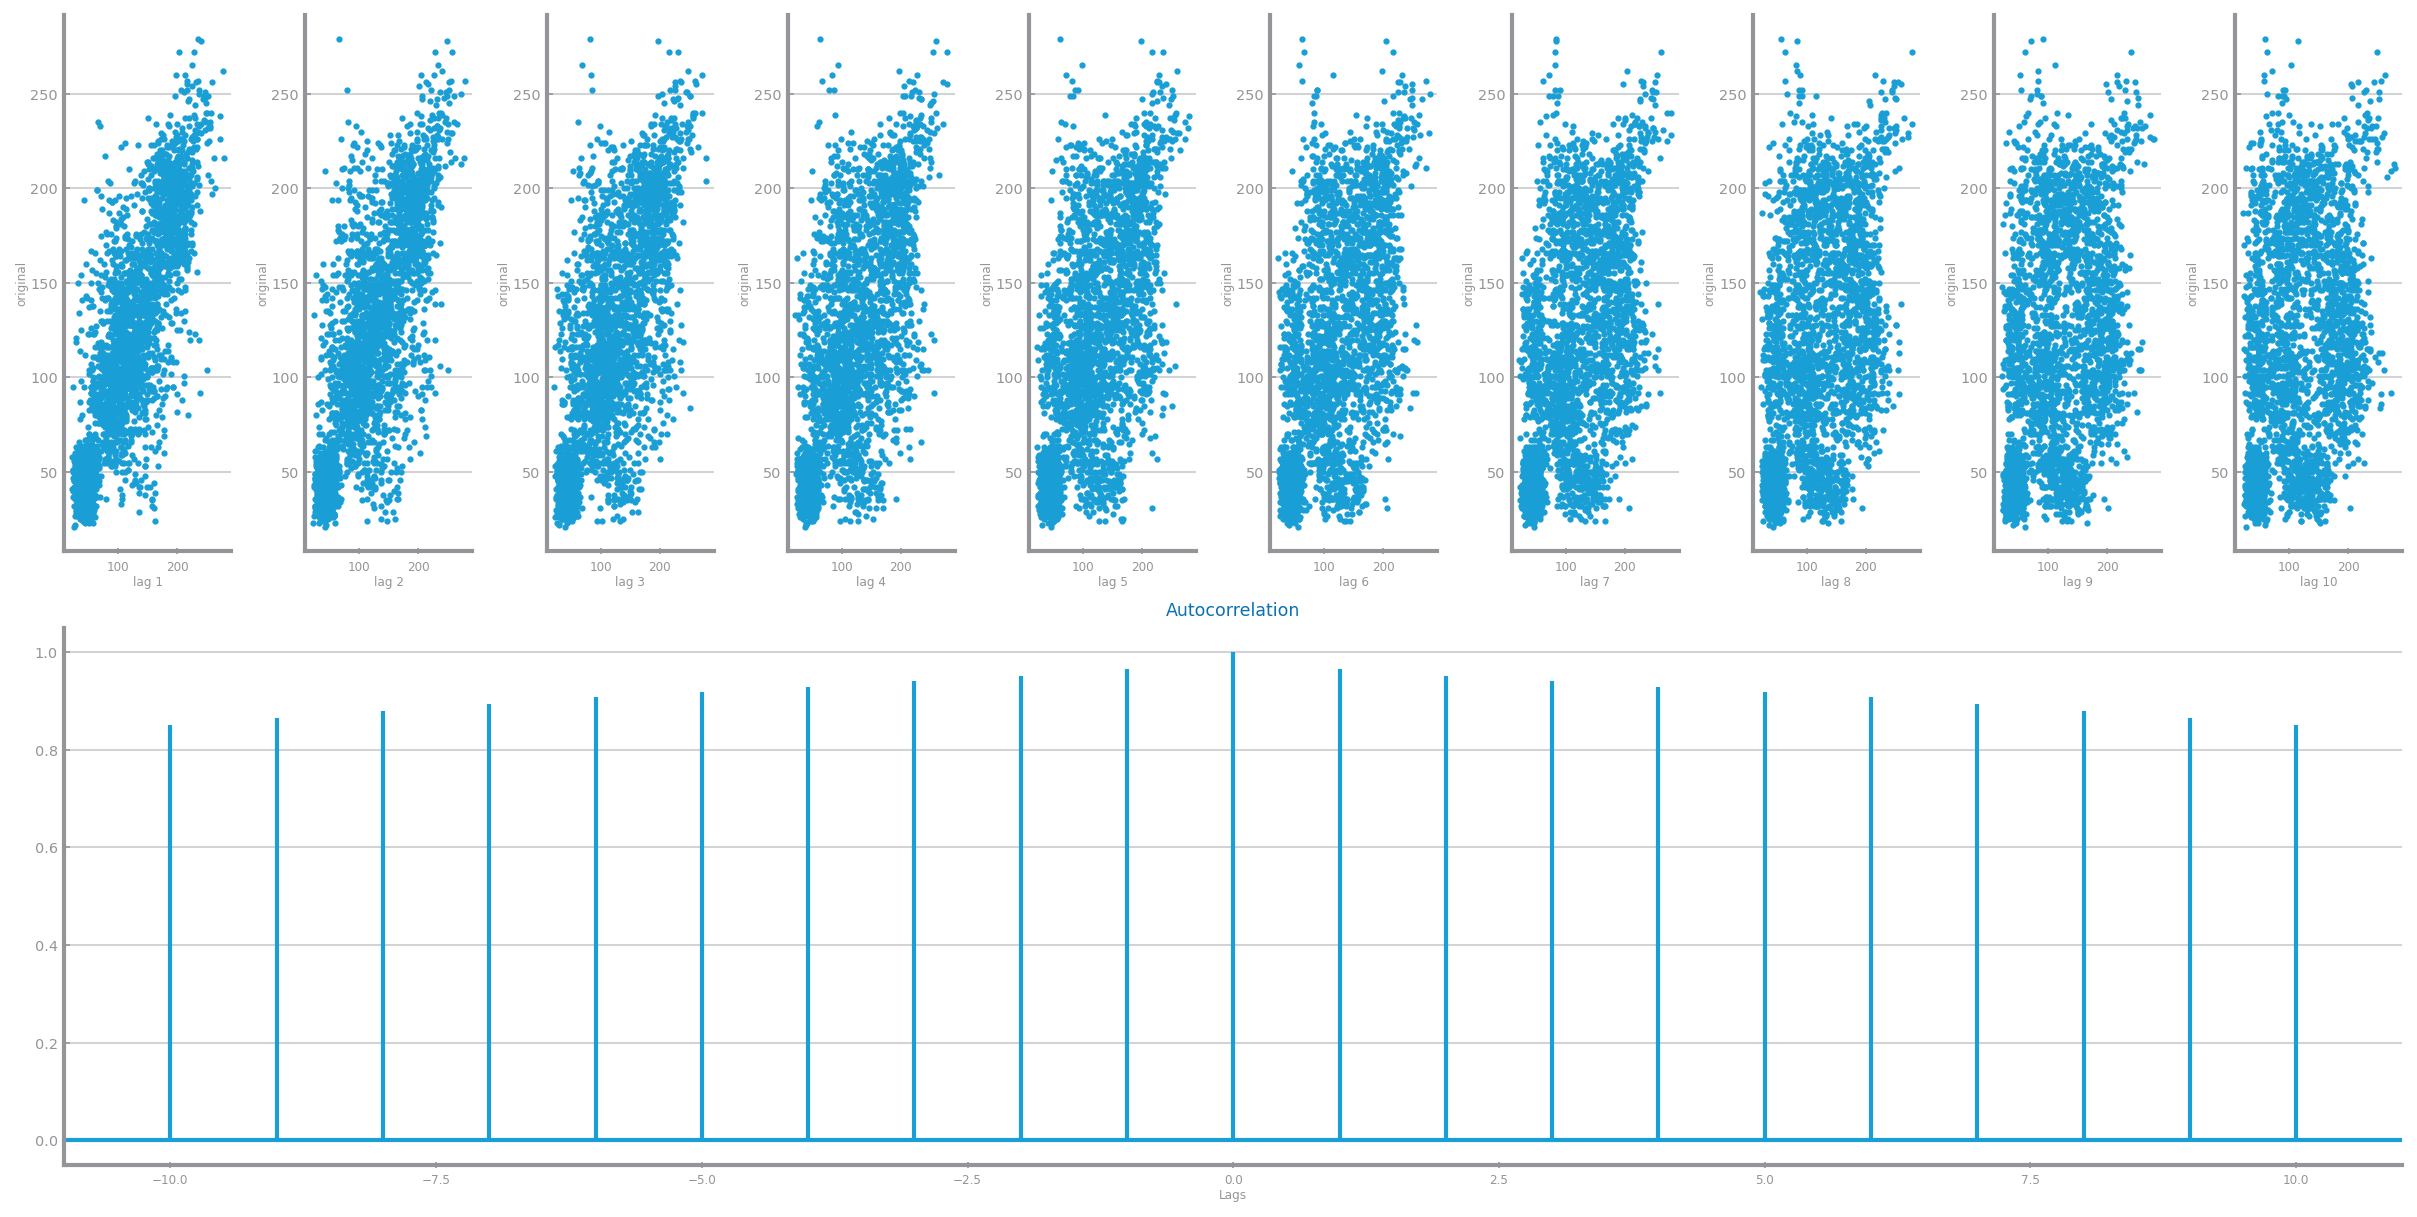

In [9]:
from matplotlib.pyplot import setp
from matplotlib.gridspec import GridSpec


def autocorrelation_study(series: Series, max_lag: int, delta: int = 1):
    k: int = int(max_lag / delta)
    fig = figure(figsize=(4 * HEIGHT, 2 * HEIGHT), constrained_layout=True)
    gs = GridSpec(2, k, figure=fig)

    series_values: list = series.tolist()
    for i in range(1, k + 1):
        ax = fig.add_subplot(gs[0, i - 1])
        lag = i * delta
        ax.scatter(series.shift(lag).tolist(), series_values)
        ax.set_xlabel(f"lag {lag}")
        ax.set_ylabel("original")
    ax = fig.add_subplot(gs[1, :])
    ax.acorr(series, maxlags=max_lag)
    ax.set_title("Autocorrelation")
    ax.set_xlabel("Lags")
    return fig


fig = autocorrelation_study(series, 10, 1)

fig.savefig(f"./images/{file_tag}autocorrelation_study.png", bbox_inches='tight')
